<h1> Python Data Notebook (Template) </h1>
<h3> Preserve this template, duplicate this file before using it!!</h3>
<strong> Author: Micah Simmerman, Nolan Ollada, Nathan Palmer </strong>

<strong>Resource URL:</strong>

<strong>Database file(s), columnar dataset(s), etc.:</strong>

# Project Description
This project will investigate data mining techniques for efficient isolation of principle classes hidden inside massive datasets (i.e., those containing millions of data points or more). This project will identify a series of robust and sequential data mining techniques that can be used to extract, clean, normalize, and prepare the data for causal analysis. Our investigation will use Principal Component Analysis (PCA) and apriori-based Data Cube techniques to observe temporal and regional trends in automotive safety. We will use the insight derived from these Data Cubes to identify and predict the principal driver classes composing the SWITRS California Collision Data Set using Decision Tree Classification (DTC), Frequent Pattern Mining (FPM), and Bayesian Belief Networks (BBN). The project will conclude with a k-fold cross validation or/or cluster based data discovery  to estimate the accuracy and usefulness of each model.

In [1]:
# Libraries and packages
import os
import sqlite3
import pandas as pd
pd.__version__
import numpy as np
from scipy import stats
from collections import Counter
import math
import seaborn as sns
import matplotlib.pyplot as plt

# SQLite db file connection is achieved in the try/except statements below. 
# TODO: add sections to read-in mySQL/PostGreSQL and csv files.

tables = []  # GLOBAL TABLE INDEX
attribute_list = []  # GLOBAL ATTRIBUTE INDEX

# NOTE: always store the switrs.sqlite file in the parent directory where this python notebook is kept.
db_file = '../switrs.sqlite'  # name the db file downloaded directly from https://www.kaggle.com/datasets/alexgude/california-traffic-collision-data-from-switrs
sqliteConnection = sqlite3.connect(db_file)

# if os.path.isfile(db_file):  # determine if there is any SQLite db file by that name exists in the specified file location.
sqliteConnection = sqlite3.connect(db_file)  # establish a connection if the file does exist.
cursor = sqliteConnection.cursor()  # create a cursor object.
table_query = 'SELECT name from sqlite_master where type= "table"'
cursor.execute(table_query)
result = cursor.fetchall()
print()
print(len(result), "tables found.")
for i in range(len(result)):
    tables.append(result[i][0])
    # print(result[i][0])

# the second part of the algorithm extracts the attributes of each table identified in the first step and places them into a 2D list. 
for table in tables:
    consumer_complaints_count_records = "PRAGMA table_info("
    consumer_complaints_count_records += str(table)  + ");"  # build the sqlite query string using the current list object
    cursor.execute(consumer_complaints_count_records)  # execute the query string
    result = cursor.fetchall()  # collect the results
    temp_list = []
    for item in result:
        temp_list.append(item[1])
    attribute_list.append(temp_list)  # export the list attribute table after it is built
    # print("The", table, "table contains", result[0][0], "data points")  # print the results
    # print()
print("Table and attribute name extraction completed successfully.")


print('DB file and Dependencies Loaded.')  
# else:
#     print(os.path.isfile(db_file), "No SQLite file detected.")  # otherwise, print the connection status.


4 tables found.
Table and attribute name extraction completed successfully.
DB file and Dependencies Loaded.


Start by collecting information about the table names in the database.

In [2]:
# Now we have a list of tables and their respective attribute columns.
print("Tables in the database: ", tables)
print("Attribute list: ", attribute_list)

Tables in the database:  ['case_ids', 'collisions', 'victims', 'parties']
Attribute list:  [['case_id', 'db_year'], ['case_id', 'jurisdiction', 'reporting_district', 'population', 'county_city_location', 'county_location', 'chp_beat_type', 'primary_road', 'secondary_road', 'distance', 'direction', 'intersection', 'weather_1', 'weather_2', 'state_highway_indicator', 'caltrans_county', 'caltrans_district', 'state_route', 'route_suffix', 'postmile_prefix', 'postmile', 'location_type', 'ramp_intersection', 'side_of_highway', 'tow_away', 'collision_severity', 'killed_victims', 'injured_victims', 'party_count', 'primary_collision_factor', 'pcf_violation_code', 'pcf_violation_category', 'type_of_collision', 'motor_vehicle_involved_with', 'pedestrian_action', 'road_surface', 'road_condition_1', 'road_condition_2', 'lighting', 'control_device', 'chp_road_type', 'pedestrian_collision', 'bicycle_collision', 'motorcycle_collision', 'truck_collision', 'not_private_property', 'alcohol_involved', 'st

## Data Cleaning and Preprocessing
run the code below to remove the attributes in the remove_cols_collisions and remove_cols_parties tables specified. You can run the above 2 code blocks again to see that the specified attributes were removed.

Running the following cell twice currently results in an error. 

    RATIONAL FOR ATTRIBUTE COLUMN REMOVAL:
    collisions.officer_id: responding officers identification is not relevant to the factors of a collision.
    collisions.chp_shift: chp_shift indicates the work shift period of the responding officer. More accurate temporal measurements exist.
    collisions.special_condition: 
    collisions.beat_type: 
    collisions.city_division_lapd: 
    collisions.chp_beat_class: 
    collisions.beat_number: 
    collisions.pcf_violation: 
    collisions.pcf_violation_subsection: 
    collisions.hit_and_run: 
    collisions.process_date: 

    For a complete list of attribute definitions, please visit: https://peteraldhous.com/Data/ca_traffic/SWITRS_codebook.pdf

# Warning:
The following cell block removes unwanted attribute columns from the SWITRS database file and will take a long time to execute. Repeated requests should not impose any harm on the database file. Time to complete last session = 14 minutes. 

In [3]:
# Increase the page count and turn off SQLite Journaling Mode to reduce the overhead of the SQLite ALTER TABLE statements.
increase_page_count = "PRAGMA max_page_count = 2147483646;"
turn_off_journal = "PRAGMA journal_mode=OFF"
cursor.execute(increase_page_count)
cursor.execute(turn_off_journal)  # turn off the journaling mode (temporarily) to avoid exceeding local disk space limitations.
sqliteConnection.commit()

In [65]:
# PLACE AN INDEX ON 'case_id' IN ALL THREE TABLES TO FACILITATE DRILL-THROUGH QUERIES. 
try:
    set_case_id_index_collisions = "CREATE INDEX collisions_case_id ON collisions(case_id);"
    set_case_id_index_parties = "CREATE INDEX parties_case_id ON parties(case_id);"
    set_case_id_index_victims = "CREATE INDEX victims_case_id ON victims(case_id);"
    cursor.execute(set_case_id_index_collisions)
    cursor.execute(set_case_id_index_parties)
    cursor.execute(set_case_id_index_victims)
    sqliteConnection.commit()
except:
    print("SWITRS DB file contains the following indices...") 
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print("collisions table index 'collisions_case_id' created on 'case_id' attribute column.") 
    print("parties table index 'parties_case_id' created on 'case_id' attribute column.")
    print("victims table index 'victims_case_id' created on 'case_id' attribute column.")

SWITRS DB file contains the following indices...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
collisions table index 'collisions_case_id' created on 'case_id' attribute column.
parties table index 'parties_case_id' created on 'case_id' attribute column.
victims table index 'victims_case_id' created on 'case_id' attribute column.


In [67]:
# Include the attribute columns you wish to remove in the list(s) below.
remove_cols_collisions = ["officer_id", "chp_shift", "special_condition", "beat_type", "city_division_lapd", "chp_beat_class", "beat_number", "pcf_violation", "pcf_violation_subsection", "hit_and_run", "process_date"]
remove_cols_parties = ["hazardous_materials", "oaf_violation_code"]
# Alternatively, we can identify the attribute ids with a string and concatenate it into a SQLite query statement.
# remove_cols_collisions = "officer_id, chp_shift, special_condition, beat_type, city_division_lapd, chp_beat_class, beat_number, pcf_violation, pcf_violation_subsection, hit_and_run, process_date"
# remove_cols_parties = "hazardous_materials, oaf_violation_code"

try:
    for col in remove_cols_collisions:
        drop_collisions_columns = "ALTER TABLE collisions DROP  "
        drop_collisions_columns += col  + ";" 
        cursor.execute(drop_collisions_columns)
        sqliteConnection.commit()
        print("Removed", col, "from the 'collisions' table.")
        print("working...")
    for attrib in remove_cols_parties:
        drop_parties_columns = "ALTER TABLE parties DROP "
        drop_parties_columns += attrib  + ";" 
        cursor.execute(drop_parties_columns)
        sqliteConnection.commit()
        print("Removed", attrib, "from the 'parties' table")
        print("working...")
    print("The identified attribute columns successfully removed from the switrs database file.")
    print("Overwrite ../switrs.sqlite with a newly decompressed switrs source file to reverse these changes")
except:
    print("These columns have been removed already.")

## CODE FOR RESTORING JOURNAL MODE (DEFAULT = OFF)
# turn_journal_on = "PRAGMA journal_mode=ON"  # let's leave this off for now. 
# cursor.execute(turn_journal_on)  # turn the journaling mode back on so we can roll-back our changes.
# sqliteConnection.commit()  # commit the change to the database file.
# print("journal mode is back on.")

These columns have been removed already.


In [68]:
# Now we have a list of tables and their respective attribute columns.+
for i in range(len(tables)):
    print(tables[i], "has attributes:", attribute_list[i])
    # print(attribute_list[i])
    

case_ids has attributes: ['case_id', 'db_year']
collisions has attributes: ['case_id', 'jurisdiction', 'reporting_district', 'population', 'county_city_location', 'county_location', 'chp_beat_type', 'primary_road', 'secondary_road', 'distance', 'direction', 'intersection', 'weather_1', 'weather_2', 'state_highway_indicator', 'caltrans_county', 'caltrans_district', 'state_route', 'route_suffix', 'postmile_prefix', 'postmile', 'location_type', 'ramp_intersection', 'side_of_highway', 'tow_away', 'collision_severity', 'killed_victims', 'injured_victims', 'party_count', 'primary_collision_factor', 'pcf_violation_code', 'pcf_violation_category', 'type_of_collision', 'motor_vehicle_involved_with', 'pedestrian_action', 'road_surface', 'road_condition_1', 'road_condition_2', 'lighting', 'control_device', 'chp_road_type', 'pedestrian_collision', 'bicycle_collision', 'motorcycle_collision', 'truck_collision', 'not_private_property', 'alcohol_involved', 'statewide_vehicle_type_at_fault', 'chp_vehi

In [81]:
# ENUMERATE DATA POINTS
data_point_count = 0
for table in range(len(tables)):
    count_records = 'SELECT COUNT(*) FROM ('  # start the string.
    count_records += tables[table] + ");"  # concatenate the variable and complete the string build.
    cursor.execute(count_records)  # 
    result = cursor.fetchall()
    data_point_count += result[0][0]
    print("The", tables[table], "table contains", result[0][0], "data points.")

print("Current number of data points accross tables of 'switrs.sqlite' database file =", data_point_count)

The case_ids table contains 9424334 data points.
The collisions table contains 9424334 data points.
The victims table contains 9639334 data points.
The parties table contains 18669166 data points.
Current number of data points accross tables of 'switrs.sqlite' database file= 47157168


### Data Sampling and Principal Component Analysis

Below, we create a Pandas DataFrame consisiting of 10000 random entries from the collisions table. This will speed up testing performance of any data cleaning and PCA algorithms. 

The code within this block populates the case_id list object with the case_id values collected in the random sample procedure. This list is then used to perform a set selection using a "SELECT FROM WHERE case_id IN ..." type SQLite query construction. The nature of set queries and generation of the index on the 'case_id' attribute column of each table makes this a very speedy query set. 

### Generating a Training Set with n=10,000 

The following code section produces three randomly sampled dataframe objects composed of randomly selected datapoints pulled from the 'collisions', 'parties', and 'victims' tables using a common 'case_id' sampling index (in the form of a python list). 

In [82]:
# Create a python list of the 'case_id' values for the n=10,000 random sample set that we are about to generate.
case_ids = []  # this list will contain each 'case_id'

# The estimated completion time is 20.5 seconds.
print("Generating a n=10,000 random sample from the switrs.sqlite database file...")
print("#####################################################################################################")
# Read 10000 random samples from the collisions table into a local pandas DataFrame. (BOOTSTRAP SAMPLING)
collisions_random_10000_df = pd.read_sql_query("SELECT * FROM collisions ORDER BY RANDOM() LIMIT 10000;", sqliteConnection)
print()
print("collisions_random_10000_df.head()...")
print(collisions_random_10000_df.head())
print(collisions_random_10000_df['case_id'].values[0])

# populate the case_ids list
for i in collisions_random_10000_df.index:
    case_ids.append(collisions_random_10000_df['case_id'].values[i])

# Check our progress.
print("SAMPLE 'case_id's:")
print(case_ids)  # USE THIS LIST TO CALL THE DATA OBJECTS IN FROM THE OTHER TABLES (I.e., 'parties' and 'victims'). 

Generating a n=10,000 random sample from the switrs.sqlite database file...
#####################################################################################################

collisions_random_10000_df.head()...
    case_id  jurisdiction reporting_district        population  \
0   3558880        1900.0               0333    25000 to 50000   
1  90240609        9540.0               None           >250000   
2  90780533        9850.0               None   50000 to 100000   
3   3411305        1900.0               0452  100000 to 250000   
4   6841108        3600.0              HI017    25000 to 50000   

  county_city_location county_location chp_beat_type  \
0                 1939     los angeles       not chp   
1                 1942     los angeles    interstate   
2                 3612  san bernardino    interstate   
3                 1949     los angeles       not chp   
4                 3618  san bernardino       not chp   

                     primary_road      secondary_r

In [39]:
# Build a tuple formatted string that contains the case_id's we are interested in.
sample_set_case_ids = "("  # we will close this when we append the other argument strings.
for i in case_ids:
    sample_set_case_ids += i 
    sample_set_case_ids += ", "  # delete this substring before closing the string.
sample_set_case_ids = sample_set_case_ids[:-2]  # 
sample_set_case_ids += ") ORDER BY case_id DESC;"

# Complete each of the sql queries
parties_query = "SELECT * FROM parties WHERE case_id IN " + sample_set_case_ids
victims_query = "SELECT * FROM victims WHERE case_id IN " + sample_set_case_ids

# PULL IN THE CORRESPONDING RECORDS FROM 'parties' and 'victims' TABLES
parties_matching_10000_df = pd.read_sql_query(parties_query, sqliteConnection)
victims_matching_10000_df = pd.read_sql_query(victims_query, sqliteConnection)

# Check our work
print("(n=10,000) data frame composed of 'parties' table tuples, associated with 'case_id's found in 'collisions_random_10000_df'")
print("#######################################################")
print(".head() view of the 'parties_matching_10000_df' dataframe object:")
print(parties_matching_10000_df.head())
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print()
print("(n=10,000) data frame composed of 'victims' table tuples, associated with 'case_id's found in 'collisions_random_10000_df'")
print("#######################################################")
print(".head() view of the 'victims_matching_10000_df' dataframe object:")
print(victims_matching_10000_df.head())

(n=10,000) data frame composed of 'parties' table tuples, associated with 'case_id's found in 'collisions_random_10000_df'
#######################################################
.head() view of the 'parties_matching_10000_df' dataframe object:
         id  case_id  party_number party_type  at_fault party_sex  party_age  \
0  10490580  9268246             2  bicyclist         0      male       59.0   
1  10490579  9268246             1     driver         1    female        NaN   
2  10486768  9264863             2     driver         0      male       21.0   
3  10486767  9264863             1     driver         1      None        NaN   
4  10485119  9263839             2     driver         0    female       47.0   

          party_sobriety party_drug_physical direction_of_travel  ...  \
0  had not been drinking                None               south  ...   
1     impairment unknown                   G               south  ...   
2  had not been drinking                None           

Here we find all the numeric and discrete attributes in the collisions table, so we can more easily see which should be included in specific tests, or normalized.

In [84]:
# Using your dataframe 'collisions_random_10000_df'
numeric_cols = collisions_random_10000_df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = collisions_random_10000_df.select_dtypes(include=['object']).columns.tolist()

print("Numeric columns: ", numeric_cols)
print("Categorical columns: ", categorical_cols)

Numeric columns:  ['jurisdiction', 'distance', 'intersection', 'state_highway_indicator', 'caltrans_district', 'state_route', 'postmile', 'tow_away', 'killed_victims', 'injured_victims', 'party_count', 'pedestrian_collision', 'bicycle_collision', 'motorcycle_collision', 'truck_collision', 'not_private_property', 'alcohol_involved', 'severe_injury_count', 'other_visible_injury_count', 'complaint_of_pain_injury_count', 'pedestrian_killed_count', 'pedestrian_injured_count', 'bicyclist_killed_count', 'bicyclist_injured_count', 'motorcyclist_killed_count', 'motorcyclist_injured_count', 'latitude', 'longitude']
Categorical columns:  ['case_id', 'reporting_district', 'population', 'county_city_location', 'county_location', 'chp_beat_type', 'primary_road', 'secondary_road', 'direction', 'weather_1', 'weather_2', 'caltrans_county', 'route_suffix', 'postmile_prefix', 'location_type', 'ramp_intersection', 'side_of_highway', 'collision_severity', 'primary_collision_factor', 'pcf_violation_code', '

Below, we will create a DataFrame containing attributes that are most intuitively associated with collisions. We can also print out a row to see what the data looks like.

In [83]:
collisions_important_df = collisions_random_10000_df[['intersection', 'state_highway_indicator', 'killed_victims', 
    'injured_victims', 'party_count', 'pedestrian_collision', 'bicycle_collision', 'motorcycle_collision', 
    'truck_collision', 'alcohol_involved', 'population', 'weather_1', 'location_type', 'collision_severity', 
    'primary_collision_factor', 'type_of_collision', 'pedestrian_action', 'road_surface', 'road_condition_1', 
    'lighting', 'control_device']]

collisions_important_df['alcohol_involved'] = collisions_important_df['alcohol_involved'].fillna(0) # Filling in 0 for NaN values in alcohol involvement so they can be used in calculations.

print(collisions_important_df.head(1)) # Print one row of the table so we can see what it looks like

   intersection  state_highway_indicator  killed_victims  injured_victims  \
0           1.0                      1.0             0.0              0.0   

   party_count  pedestrian_collision  bicycle_collision  motorcycle_collision  \
0            2                     0                  0                     0   

   truck_collision  alcohol_involved  ... weather_1 location_type  \
0                0               0.0  ...     clear          ramp   

     collision_severity primary_collision_factor type_of_collision  \
0  property damage only   vehicle code violation         sideswipe   

        pedestrian_action road_surface road_condition_1  \
0  no pedestrian involved          dry           normal   

                  lighting control_device  
0  dark with street lights    functioning  

[1 rows x 21 columns]


C:\Users\jmica\AppData\Local\Temp\ipykernel_27400\3099857728.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collisions_important_df['alcohol_involved'] = collisions_important_df['alcohol_involved'].fillna(0) # Filling in 0 for NaN values in alcohol involvement so they can be used in calculations.


## Some Visualizations

Lets make some histograms showing the involvement frequencies of driving condition factors.

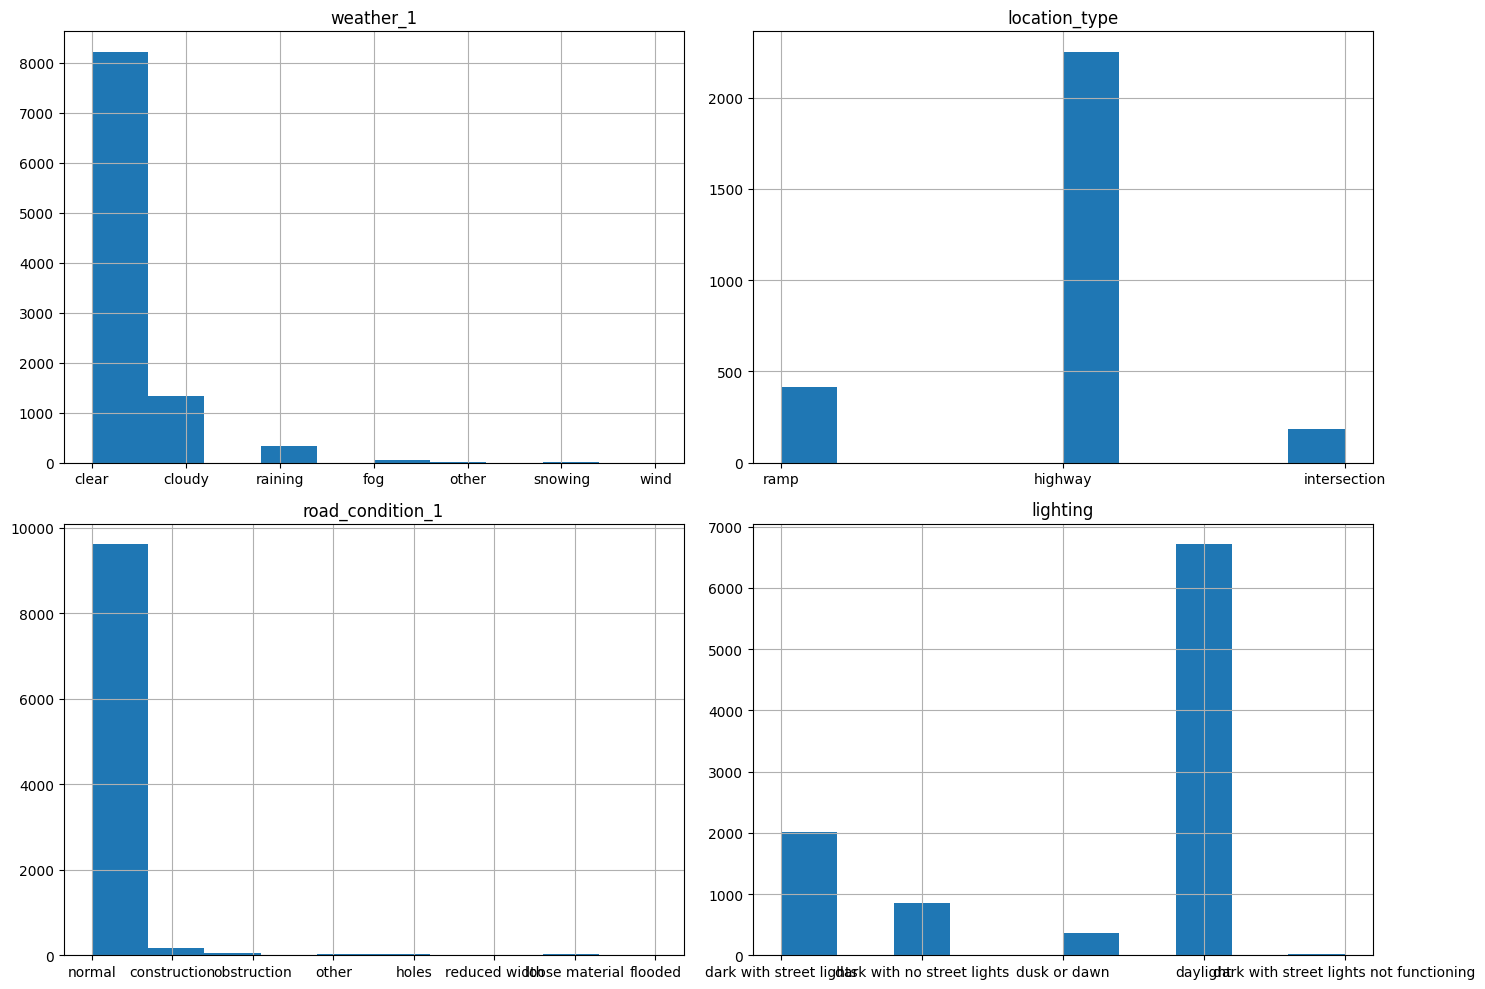

In [85]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
collisions_important_df['weather_1'].hist()
plt.title('weather_1')

plt.subplot(2, 2, 2)
collisions_important_df['location_type'].hist()
plt.title('location_type')

plt.subplot(2, 2, 3)
collisions_important_df['road_condition_1'].hist()
plt.title('road_condition_1')

plt.subplot(2, 2, 4)
collisions_important_df['lighting'].hist()
plt.title('lighting')

plt.tight_layout()
plt.show()

Now we should take a look at frequencies of human behaviors that contribute to accidents.

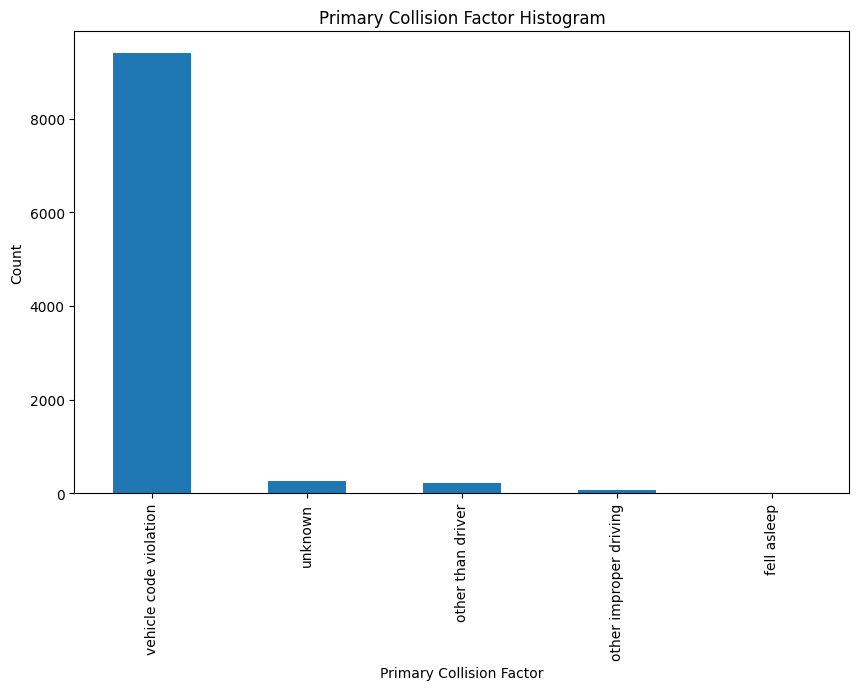

In [18]:
plt.figure(figsize=(10, 6))  # Set the figure size
collisions_important_df['primary_collision_factor'].value_counts().plot(kind='bar')
plt.title('Primary Collision Factor Histogram')  # Set the title
plt.xlabel('Primary Collision Factor')  # Set x-axis label
plt.ylabel('Count')  # Set y-axis label
plt.show()

Below we form a correlation matrix for the numeric attributes of the collisions table. This will help us visualize the relationships that attributes have with each other.

In [19]:
numeric_cols_df = collisions_important_df.select_dtypes(include=[np.number])
# Using your dataframe 'collisions_random_10000_df'
correlation_matrix = numeric_cols_df.corr()

# Printing correlation matrix
print(correlation_matrix)

                         intersection  state_highway_indicator  \
intersection                 1.000000                -0.283647   
state_highway_indicator     -0.283647                 1.000000   
killed_victims              -0.012528                 0.008124   
injured_victims              0.130725                -0.044783   
party_count                  0.041859                 0.012284   
pedestrian_collision         0.048578                -0.102581   
bicycle_collision            0.072667                -0.092591   
motorcycle_collision        -0.008799                 0.020541   
truck_collision             -0.059831                 0.134607   
alcohol_involved            -0.042708                -0.056140   

                         killed_victims  injured_victims  party_count  \
intersection                  -0.012528         0.130725     0.041859   
state_highway_indicator        0.008124        -0.044783     0.012284   
killed_victims                 1.000000         0.0596

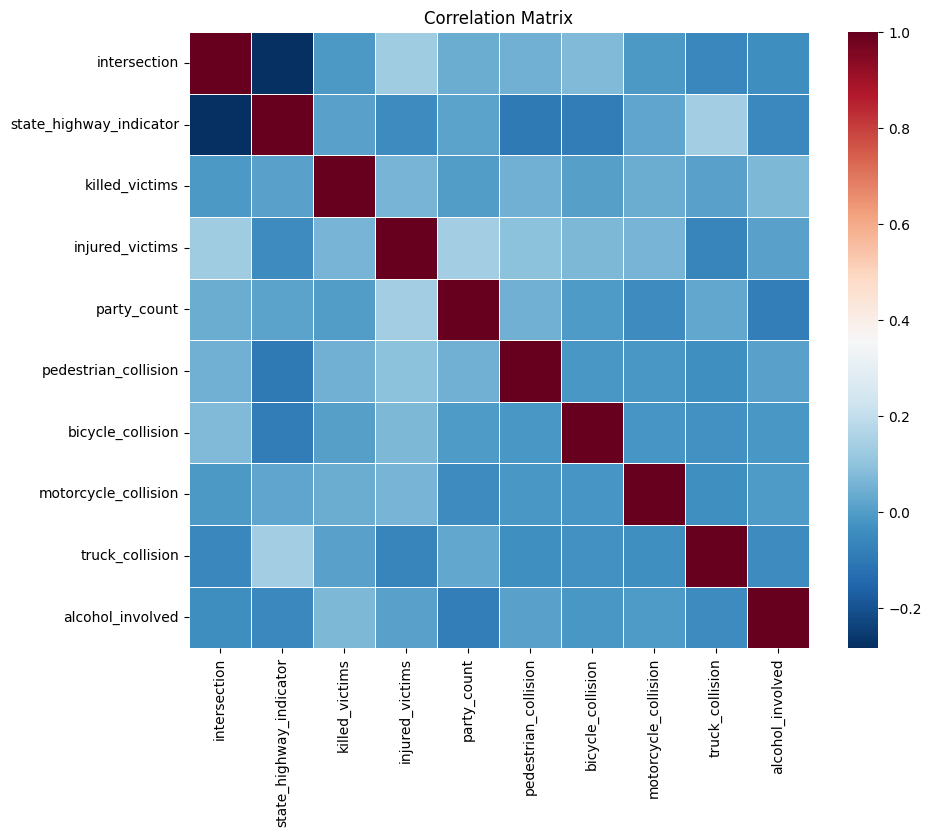

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))  # Optional: You can set the figure size

sns.heatmap(correlation_matrix, 
            xticklabels=correlation_matrix.columns, 
            yticklabels=correlation_matrix.columns, 
            cmap='RdBu_r', 
            annot=False, 
            linewidth=0.5)

plt.title('Correlation Matrix')
plt.show()

#### Parties Table

In [8]:
# RANDOM SAMPLER STUB FOR 'parties' table
# Read 10000 randomly selected sqlite table query tuples into a local pandas DataFrame
parties_random_10000_df = pd.read_sql_query("SELECT * FROM parties ORDER BY RANDOM() LIMIT 10000;", sqliteConnection)
print(parties_random_10000_df.head())

        id  case_id  party_number      party_type  at_fault party_sex  \
0   160569  3653987             2  parked vehicle         0      None   
1  5746405  3074257             2          driver         0      male   
2  6469431  8507295             1          driver         1      male   
3  4945871  2659636             1          driver         1      male   
4  5458574  7158867             1          driver         1      male   

   party_age         party_sobriety party_drug_physical direction_of_travel  \
0        NaN         not applicable      not applicable               south   
1       51.0  had not been drinking                None                west   
2       44.0  had not been drinking                None                east   
3       29.0  had not been drinking                None                west   
4       18.0  had not been drinking                None                east   

   ... other_associate_factor_2 party_number_killed party_number_injured  \
0  ...    

#### Victims Table

In [10]:
# RANDOM SAMPLER STUB FOR 'victims' table
# Read 10000 randomly selected sqlite table query tuples into a local pandas DataFrame
victims_random_10000_df = pd.read_sql_query("SELECT * FROM victims ORDER BY RANDOM() LIMIT 10000;", sqliteConnection)
print(victims_random_10000_df.head())

        id              case_id  party_number victim_role victim_sex  \
0  1367181              1339627             2      driver       male   
1  1988026              6151672             2   passenger       male   
2  1284666              1255492             2   passenger     female   
3  8667800  9525011104100016575             2   passenger     female   
4  4993188              9165698             3      driver       male   

   victim_age victim_degree_of_injury victim_seating_position  \
0        53.0       complaint of pain                  driver   
1        88.0               no injury        passenger seat 6   
2         8.0               no injury        passenger seat 6   
3        59.0       complaint of pain        passenger seat 5   
4        28.0       complaint of pain                  driver   

   victim_safety_equipment_1  victim_safety_equipment_2 victim_ejected  
0       air bag not deployed  lap/shoulder harness used    not ejected  
1               not required  

In [36]:
# # Create a view using SQLite so that we can access all data as if it were a single data point object.
# # Since collisions, parties, and victims contain all of the information we need, we would like to join these three tables to create our random samples.
# create_sql_view = """ 
#                     SELECT * 
#                     FROM collisions
#                     INNER JOIN parties ON collisions.case_id = parties.case_id
#                     INNER JOIN victims ON parties.case_id = victims.case_id AND parties.party_number = victims.party_number
#                     ORDER BY RANDOM() 
#                     LIMIT 100;
#                 """ 
# cursor.execute(create_sql_view)
# result = cursor.fetchall()


OperationalError: database or disk is full

In [ ]:
print(result)

[]


In [ ]:
# This cell will defines a first round Data Cube Function(s)
create_data_cube = """SELECT 
    c1, c2, AGGREGATE_FUNCTION(c3)
FROM
    table_name
GROUP BY CUBE(c1 , c2);"""

### Not using stuff past this line

The functions below currently only work on csv files. Add a conditional behavior to these functions and extend them to extract equivalent data from a table in an SQLite db file. 

In [ ]:
# The following are basic statistic functions that can be used as helper routines in longer extraction/cleaning/clustering efforts. 
# The remainder of the notebook contains code written to examine the telescope data. You can to generalize each function or create a
# python scrip to examine tabular data files in a terminal window.

# There are many methods that you can use to extract SQLite table data into a pandas dataframe or a numpy data object to generate graphics, 
# or perform package-based statistical testing. At this point in the notebook (and as of 11-June-2023).

import pandas as pd
import numpy as np

# maximum value (max)
def maximum(filename, attribute_number):
    if attribute_number < 1 or attribute_number > 10 or attribute_number%1!=0:
        return None
    else:
        MC_telescope_data = pd.read_csv(filename, header=None)  # read the file into a pandas dataframe
        column = MC_telescope_data.iloc[:,attribute_number]  # project the indicated column from the pandas dataframe
        result = column.max()  # find the maximum value
        return round(result, 2)

# minimum value (min)
def minimum(filename, attribute_number):
    if attribute_number < 1 or attribute_number > 10 or attribute_number%1!=0:
        return None
    else:
        MC_telescope_data = pd.read_csv(filename, header=None)
        column = MC_telescope_data.iloc[:,attribute_number]
        result = column.min()  # find the minimum value
        return round(result, 2)

# average (mean)
def mean(filename, attribute_number):
    if attribute_number < 1 or attribute_number > 10 or attribute_number%1!=0:
        return None
    else:
        MC_telescope_data = pd.read_csv(filename, header=None)
        column = MC_telescope_data.iloc[:,attribute_number]
        result = column.mean()  # calculate the average value
        return round(result, 2)

# standard deviation
def std(filename, attribute_number):
    if attribute_number < 1 or attribute_number > 10 or attribute_number%1!=0:
        return None
    else:
        MC_telescope_data = pd.read_csv(filename, header=None)
        column = MC_telescope_data.iloc[:,attribute_number]
        result = column.std()  # calculate standard deviation
        return round(result, 2)

# first quantile, Q1
def q1(filename, attribute_number):
    if attribute_number < 1 or attribute_number > 10 or attribute_number%1!=0:
        return None
    else:
        MC_telescope_data = pd.read_csv(filename, header=None)
        MC_telescope_df = pd.DataFrame(MC_telescope_data)
        column = MC_telescope_df.iloc[:,attribute_number]
        result = column.quantile([0.25]).values[0]
        return round(result, 2)

# third quantile, Q3
def q3(filename, attribute_number):
    if attribute_number < 1 or attribute_number > 10 or attribute_number%1!=0:
        return None
    else:
        MC_telescope_data = pd.read_csv(filename, header=None)
        MC_telescope_df = pd.DataFrame(MC_telescope_data)
        column = MC_telescope_df.iloc[:,attribute_number]
        result = column.quantile([0.75]).values[0]
        return round(result, 2)

# median, Q2
def median(filename, attribute_number):
    if attribute_number < 1 or attribute_number > 10 or attribute_number%1!=0:
        return None
    else:
        MC_telescope_data = pd.read_csv(filename, header=None)
        MC_telescope_df = pd.DataFrame(MC_telescope_data)
        column = MC_telescope_df.iloc[:,attribute_number]  # slice the indiced column
        result = column.quantile([0.5]).values[0]  # compute the second quantile
        return round(result, 2)

# inner-quartile range
def iqr(filename, attribute_number):
    if attribute_number < 1 or attribute_number > 10 or attribute_number%1!=0:
        return None
    else:
        iqr = float(q3(filename, attribute_number))-float(q1(filename, attribute_number))
        # return "{:.2f}".format(iqr)  # format to 2 decimal places.
        return round(iqr, 2)

# N (number of objects)
def count(filename, attribute_number):
    if attribute_number < 1 or attribute_number > 10 or attribute_number%1!=0:
        return None
    else:
        MC_telescope_data = pd.read_csv(filename, header=None)
        MC_telescope_df = pd.DataFrame(MC_telescope_data)
        column = MC_telescope_df.iloc[:,attribute_number]  # slice the indicated column
        result = column.count()  # count 
        return result

In [ ]:
# OUTPUT TESTING
print("N:", count("", 7))  # N
print("Q1:", q1("", 7))  # Q1
print("median:", median("", 7))  # Median (Q2)
print("Q3:", q3("", 7))  # Q3
print("IQR:", iqr("", 7))  # IQR
print("min:", minimum("", 7))  # min
print("max:", maximum("", 7))  # max
print("average:", mean("", 7))  # mean
print("std. deviation:", std("", 7))  # standard deviation

# # ERROR HANDLING
# print(maximum("magic04.data", 2.1))  # float (in-range)
# print(minimum("magic04.data", -1))  # out of bounds (less than)
# print(mean("magic04.data", 0))  # zero
# print(std("magic04.data", -1.5))  # negative out of range float
# print(q1("magic04.data", 10.5))  # positive out of range float
# print(median("magic04.data", 11))  # positive out of range (greater than)
# print(q3("magic04.data", -11.5))  # negative out of range float (less than)

FileNotFoundError: [Errno 2] No such file or directory: ''

Next create a scatter plot using the 4th and 5th attributes. 

https://realpython.com/visualizing-python-plt-scatter/

In [ ]:
import matplotlib.pyplot as plt

# attribute_names = ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'class']
# Attribute Definitions
#     1.  fLength:  continuous  # major axis of ellipse [mm]
#     2.  fWidth:   continuous  # minor axis of ellipse [mm] 
#     3.  fSize:    continuous  # 10-log of sum of content of all pixels [in #phot]
#     4.  fConc:    continuous  # ratio of sum of two highest pixels over fSize  [ratio]
#     5.  fConc1:   continuous  # ratio of highest pixel over fSize  [ratio]
#     6.  fAsym:    continuous  # distance from highest pixel to center, projected onto major axis [mm]
#     7.  fM3Long:  continuous  # 3rd root of third moment along major axis  [mm] 
#     8.  fM3Trans: continuous  # 3rd root of third moment along minor axis  [mm]
#     9.  fAlpha:   continuous  # angle of major axis with vector to origin [deg]
#    10.  fDist:    continuous  # distance from origin to center of ellipse [mm]
#    11.  class:    g,h         # gamma (signal), hadron (background)

attribute_names = ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'class']
MC_telescope_data = pd.read_csv("magic04.data", header=None)  # tabular file header is absent
MC_telescope_data.columns = attribute_names  # attach the column attribute labels
MC_telescope_df = pd.DataFrame(MC_telescope_data)  # create a pandas dataframe 


MC_telescope_data_column_4 = MC_telescope_df.iloc[:,4]  #  
MC_telescope_data_column_5 = MC_telescope_df.iloc[:,5]  # 

# KEEP THIS CODE FOR REFERENCE
# plt.plot(MC_telescope_data_column_4, MC_telescope_data_column_5, "o")  # use plt.plot, if you want it to be fast.
# plt.scatter(MC_telescope_data_column_4, MC_telescope_data_column_5)  # use plt.scatter, if you want more features.

plt.scatter(x=MC_telescope_data_column_4, y=MC_telescope_data_column_5)  # use plt.scatter, if you want to use more features.
plt.xlabel(attribute_names[3])  # 
plt.ylabel(attribute_names[4])  # 
plt.title("Scatter Plot of 4th and 5th Dimensions, MAGIC Telescope Data")
plt.savefig('scatter_plot_dimensions_4_5')
plt.show()

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
num_list = [13, 15, 16, 16, 19, 20, 20, 21, 22, 22, 25, 25, 25, 25, 30, 33, 33, 35, 35, 35, 35, 36, 40, 45, 46, 52, 70]
interval_list = {'1-5':136, '6-15':181, '16-20':178, '21-50':695, '51-80':245, '81-110':177}  # Age:Frequency


def lst_mean(lst):
    result = np.mean(lst)
    return round(result, 3)

def lst_median(lst):
    result = np.median(lst)
    return round(result, 3)

def lst_mode(lst):
    result = stats.mode(lst, keepdims=True)
    # return round(result, 3)
    return result

def lst_histogram(lst):
    a = np.array(lst)
    items = Counter(lst).keys()  # find the number of unique values in the set to set the bins
    fig, ax = plt.subplots(figsize =(5, 3))
    plt.hist(a, bins=range(np.min(lst)-5, np.max(lst)+5))

def lst_multimode(lst):
    res = []
    test_list1 = Counter(lst)
    temp = test_list1.most_common(1)[0][1]  # Extracts values of greatest frequency in the set.
    for ele in lst:
        if lst.count(ele) == temp:
            res.append(ele)
            res = list(set(res))
    # printing results
    return "Data modality = " + str(len(res)) + "; mode list = " + str(res)

def lst_midrange(lst):
    min = np.min(lst)
    max = np.max(lst)
    return round( ((min + max)/2.0), 3)

def lst_q1(lst):
    arr = np.array(lst)
    result = np.quantile(arr, 0.25)
    return round(result, 3)

def lst_q3(lst):
    arr = np.array(lst)
    result = np.quantile(arr, 0.75)
    return round(result, 3)

def cum_freq_list_from_inerval(dict):
    cumulative_freq = 0
    cumulative_freq_lst = []
    for itm in dict:
        cumulative_freq += dict[itm]  # collect the item frequency
        cumulative_freq_lst.append(cumulative_freq)
    n = cumulative_freq_lst[-1]
    return cumulative_freq_lst
    
def find_n_by_2(dict):
    cumulative_freq_lst = cum_freq_list_from_inerval(dict)
    n = cumulative_freq_lst[-1]
    n_by_2 = n/2
    return n_by_2

def find_median_bin(n_by_2, cumulative_freq_lst):
    for i in range(len(cumulative_freq_lst)):
        if n_by_2 <= cumulative_freq_lst[i]:
            return i  # returns the index of the bin the median data point belongs to. 
        
# def estimate_median(n_by_2, cumulative_freq_lst):
    

In [ ]:
# num_list = [13, 15, 16, 16, 19, 20, 20, 21, 22, 22, 25, 25, 25, 25, 30, 33, 33, 35, 35, 35, 35, 36, 40, 45, 46, 52, 70]
# interval_list = {'1-5':136, '6-15':181, '16-20':178, '21-50':695, '51-80':245, '81-110':177}  # Age:Frequency

# test the functions
print("Mean: ", lst_mean(num_list))
print("Q1: ", lst_q1(num_list))
print("Q2: ", lst_median(num_list))
print("Q3: ", lst_q3(num_list))
print(lst_multimode(num_list))
print("Midrange ((min+max)/2.0) : ", lst_midrange(num_list))

# print("The data set is bimodal, with modes 25, 35.")
print(lst_histogram(num_list))  # use this to determine the mode(s) and modality of the set. 

Mean:  29.963
Q1:  20.5
Q2:  25.0
Q3:  35.0
Data modality = 2; mode list = [25, 35]
Midrange ((min+max)/2.0) :  41.5


NameError: name 'plt' is not defined

In [ ]:
# Question #4 on Computing Statistics using a Frequency Distribution Table
# Estimated median = L + (L + ((n/2)-B)/G)*w
# L is the lower class boundary of the group containing the median
# n is the total number of values
# B is the cumulative frequency of the groups before the median group
# G is the frequency of the median group
# w is the group width

print("Cumm. frequency list:", cum_freq_list_from_inerval(interval_list))
print("n:", cum_freq_list_from_inerval(interval_list)[-1])
print("n/2:", find_n_by_2(interval_list))
print("Group Index:", find_median_bin(find_n_by_2(interval_list), cum_freq_list_from_inerval(interval_list)))
print("Median data point resides in age group: '21-50'")


Cumm. frequency list: [136, 317, 495, 1190, 1435, 1612]
n: 1612
n/2: 806.0
Group Index: 3
Median data point resides in age group: '21-50'
